<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/testing_CNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐍 Python setup

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import glob
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📀 Get the data

In [2]:
!git clone https://github.com/darisoy/EE596_Project.git

Cloning into 'EE596_Project'...
remote: Enumerating objects: 2563, done.
remote: Counting objects: 100% (2563/2563), done.
remote: Compressing objects: 100% (2560/2560), done.
remote: Total 2563 (delta 8), reused 2540 (delta 1), pack-reused 0
Receiving objects: 100% (2563/2563), 36.72 MiB | 36.33 MiB/s, done.
Resolving deltas: 100% (8/8), done.


# 😷 Get random mask

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, min_size=1000).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [55]:
def mask_out(img, output, thres=0.7):
    for idx, box in enumerate(output[0]['boxes'].tolist()):
        score = output[0]['scores'][idx].tolist()
        if score > thres: 
            mask = output[0]['masks'][idx][0].detach().cpu().numpy()
            mask[mask > 0.2] = 1
            mask = cv2.resize(mask, dsize=(img.shape[1], img.shape[0]))
            visMask = (255-(mask * 255)).astype("uint8")
            img = cv2.bitwise_and(img, img, mask=visMask)
    return img

In [56]:
trf = T.Compose([T.ToTensor()])
def random_mask(i):
    maskname = '/content/EE596_Project/data/furnished/'+str(random.randint(0, 1227))+'.jpg'
    imagename = '/content/EE596_Project/data/empty/'+str(i)+'.jpg'
    model.eval()
    image = Image.open(glob.glob(maskname)[0])
    input = trf(image)
    input = torch.unsqueeze(input, 0).to(device)
    output = model(input)
    return cv2.imread(imagename), mask_out(cv2.imread(imagename), output)

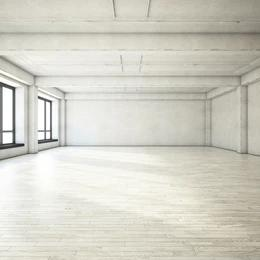

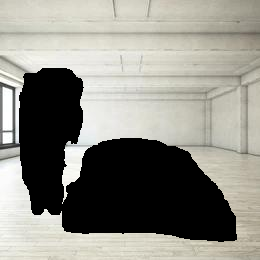

In [57]:
masked_images = []
for i in random.sample(range(0, 1000), 1):
    orig, masked = random_mask(i)
    cv2_imshow(orig)
    cv2_imshow(masked)

# 🎨 Fill in the gaps

In [49]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = ConvAutoEncoder()
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [52]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in random.sample(range(0, 100), 1):
        orig, masked = random_mask(i)
        orig, masked = torch.tensor(orig).to(device), torch.tensor(masked).to(device)
        optimizer.zero_grad()
        pred = filler(masked.unsqueeze(dim=0))
        loss = criterion(pred, orig) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('Train Epoch: %d \tLoss: %.6f' % (epoch, total_loss))

RuntimeError: ignored